<a id='Abstract'></a>
# World Development Indicators Milestone Report
-------

## Abstract

Through analysis, we have found that:
- Countries change income groups from year to year
- Higher income groups are growing while lower income groups are shrinking.
- Features are showing a growth in access and standards of living among all income groups.
- This all leads to the world becoming more developed.


The major indicator that determines income group is GNI per capita.  Countries fall into certain groups based off of this indicator.  This indicator is also correlated to many world development indicators and is worth a deep dive.

In analyzing our data, we were able to separate our indicators into various categories:
- Economic Policy and Debt
- Education and Gender Issues
- Access to Advanced Communications
- Environment, Resources and Population
- Social Protection and Labor
- Health

As we analyzed these indicators, we have seen many patterns as they relate to income groups.  The next step is to use what we have found to begin creating a machine learning model.

<a href='#Table of Contents'>Table of Contents</a>

<a id='Table of Contents'></a>

-----
## Table of Contents 

### <a href='#Abstract'>Abstract</a>

### <a href='#Intro'>Introduction</a>

----

### <a href='#Wrangle'>Data Wrangling</a>

----

- <a href='#Import'>Import Tools</a>

- <a href='#Read'>Data Wrangling</a>

- <a href='#Standard'>Standardize Dataset</a>

- <a href='#Handle'>Handle Missing Data</a>

- <a href='#Find'>Find Income Groups</a>

- <a href='#Pivot'>Pivot Dataset</a>

- <a href='#Add'>Add Regions and Income Groups</a>

----

### <a href='#EDA'>Exploratory Data Analysis</a>

- <a href='#Executive'>Findings</a>

----

- <a href='#Import'>Read in and Separate Data, Define Functions</a>

- <a href='#Year to Year Change in Income Groups'>Year to Year Change in Income Groups</a>

- <a href='#Income Group Overview'>Income Group Overview</a>

- <a href='#Executive'>Our Findings</a>

- <a href='#Economic Policy and Debt'>Economic Policy and Debt</a>

- <a href='#Education and Gender Issues'>Education and Gender Issues</a>

- <a href='#Access to Advanced Communications'>Access to Advanced Communications</a>

- <a href='#Environment, Resources and Population'>Environment, Resources and Population</a>

- <a href='#Social Protection and Labor'>Social Protection and Labor</a>

- <a href='#Health'>Health</a>

- <a href='#Diving Deeper with Indicator Correlations'>Diving Deeper with Indicator Correlations</a>

----

### <a href='#End'>Conclusion</a>

-----  
<a id='Intro'></a>

# Introduction

There are a plethora of factors that determine how developed a country is in the world. Typically, countries are considered to be developed if they:

- Are highly industrialized.
- Have a large female workforce and women in high ranking positions.
- Use a disproportionate amount of the world’s resources.
- Have stable birth and death rates.
- Have higher levels of debt, usually for production.
- Have a high Gross Domestic Production (GDP) per Capita
- And much more.

Outside of the developed category, there are developing countries that range from being highly developed to underdeveloped. For example; although it is the world’s second largest economy, China falls into a developing country category because of the disparity in it’s wealth, quality of life, and GDP per capita. Argentina is also considered a developing country because of its political disarray, economic uncertainty and erosion of quality of life despite ranking higher in vast majorities of metrics as compared to other countries.


### Problem Statement:
Development within a country will always be a continuous journey because of ever changing conditions. In the pursuit of maintaining and upgrading these levels, we want to determine what stage of development a country is in and help it acquire the tools necessary to continue building itself.

In this project, specifically, we want to look at the income group countries fall into and their development factors in order to create a multiclass classification prediction model.

<a href='#Table of Contents'>Table of Contents</a>

<a id='Wrangle'></a>
# Data Wrangling

We were able to acquire the data from the [World Bank](https://datacatalog.worldbank.org/dataset/world-development-indicators) website.

After looking through the initial data, we discovered that three datasets were needed in order to move forward with this project.  
- WDIData.csv had information on each of the 1600 indicators for each country dealing with world development over time.
- WDISeries.csv explained each indicator and placed them into a specific topic.
- WDICountry.csv had information on the country's region, income group and more.

Through data wrangling, we were able to:
- Read in raw data
- Merge datasets
- Categorize indicators
- Drop insufficient information
- Drop unrelated columns
- Standardize column names
- Extract countries
- Drop columns with too much missing data
- Drop indicators with too much missing data
- Find the income group of each country for each year
- Drop incorrect data
- Pivot the dataset for analysis and modeling

We are left with 202 countries and 341 world development indicators.

<a href='#Table of Contents'>Table of Contents</a>

<a id='Import'></a>
### Import Tools

<a href='#Table of Contents'>Table of Contents</a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# For anova tukey analysis
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
%matplotlib inline
%matplotlib inline  

<a id='Read'></a>
### Read in Raw Data and Merge Datasets

<a href='#Table of Contents'>Table of Contents</a>

In [2]:
# WDIData has 1600 indicators for each country dealing with world development
# WDISeries explains each indicator and places them into a topic category
# WDICountry has country's region and income category

data = pd.read_csv('WDI_csv/WDIData.csv')
series = pd.read_csv('WDI_csv/WDISeries.csv')
country = pd.read_csv('WDI_csv/WDICountry.csv')

# Prepare datasets for merge
country = country[['Country Code', 'Income Group', 'Region', 'Lending category', 'Other groups']]
series['Indicator Code'] = series['Series Code'] ###
series = series.rename(columns={'Indicator Name': 'Indicator Name_series'})

# Merge datasets by 'Indicator Code' and 'Country Code'
### Will confirm 'Indicator Code' and 'Series Code' match
ds = pd.merge(data, series, how='left', on='Indicator Code')
wdi = pd.merge(ds, country, how='outer', on='Country Code')

<a id='Standard'></a>
### Standardize Dataset

<a href='#Table of Contents'>Table of Contents</a>

In [3]:
# Consolidate topics into 12 categories, each category was a set of words before the ':' in topics
wdi['Category'] = ''
categories = ([
    'Economic Policy & Debt', 
    'Education', 
    'Environment', 
    'Financial Sector', 
    'Health', 
    'Infrastructure', 
    'Social Protection & Labor', 
    'Poverty', 
    'Private Sector & Trade', 
    'Public Sector', 
    'Gender', 
    'World Bank, Global Development Finance']
)

# Topics placed in categories by matching keywords
for category in categories:
    wdi['Category'] = wdi['Category'].mask(wdi['Topic'].str.startswith(category), category)
    
# Clean category and topic values
wdi['Topic'] = wdi['Topic'].str.replace('&', 'and')
wdi['Category'] = wdi['Category'].str.replace('&', 'and')

# Remove unneccessary columns and arrange columns
wdi = wdi.rename(
    columns={'Lending category': 'Lending Category', 'Long definition': 'Long Definition', 
    'Aggregation method': 'Aggregation Method', 'Other groups': 'Other Groups'}
    )
columns = [
    'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
    'Topic', 'Category', 'Income Group', 'Region', 'Aggregation Method',
    'Lending Category', 'Other Groups', '1960', '1961', '1962', '1963',
    '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', 
    '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', 
    '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
    '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
    '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
    '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
    '2018', 'Long Definition']
wdi = wdi[columns]

# Standardize column names
wdi = wdi.rename(columns={
    'Country Name': 'country', 'Country Code':'country_code', 'Indicator Name': 'indicator', 
    'Indicator Code': 'indicator_code', 'Series Code': 'series_code', 'Topic': 'topic',
    'Category': 'category', 'Income Group': 'income_group', 'Region': 'region',
    'Aggregation Method': 'aggregation_method', 'Lending Category': 'lending_category',
    'Other Groups': 'other_groups', 'Long Definition': 'definition'})

<a id='Handle'></a>
### Handle Missing Data

<a href='#Table of Contents'>Table of Contents</a>

In [4]:
# Drop these groups from the country column using income group
wdi = wdi.dropna(subset=['income_group'])

# Drop all columns with more than 50% of it's values missing
wdi = wdi[wdi.columns[wdi.isnull().mean() < 0.5]]

# Drop indicators with too much missing values per row - missing values per indicator
# Group all indicators and count them in the year columns 
# Then find a percentage of usage rate to determine the threshold to drop null values

# Drop indicator by using sum of all the years and having a threshold

count_per_indicator = (2016-2005) * 217 # Number of countries
drop_indicators = []
for index, row in wdi.groupby('indicator').count().loc[:, '2005':'2016'].iterrows():
    if ((sum(row) / count_per_indicator) * 100) < 90:
        drop_indicators.append(index)
        
wdi = wdi[~wdi.indicator.isin(drop_indicators)]

<a id='Find'></a>
### Find Income Goups For Each Year

<a href='#Table of Contents'>Table of Contents</a>

In [5]:
# Read in new dataset and isolate relevant information
income_groups = pd.read_excel('WDI_csv/OGHIST1.xlsx', skiprows=5)
income_groups = income_groups.iloc[5:220, [0, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]


# Replace letter representations of income groups to words
def replace(col):
    return col.replace({
        'LM': 'Lower middle income', 
        'L': 'Low income', 
        'UM': 'Upper middle income', 
        'H': 'High income'
    })
income_groups = income_groups.apply(replace)

# Copy old dataset in case we need to go back
wdi_old = wdi.copy()

# Prepare and merge data
income_groups['country'] = income_groups['Data for calendar year :']
wdi = pd.merge(wdi, income_groups, how='outer', on='country')

# Rename income group columns
wdi = wdi.rename(
    columns={2005: 'ig_2005', 2006: 'ig_2006', 2007: 'ig_2007', 
             2008: 'ig_2008', 2009: 'ig_2009', 2010: 'ig_2010', 
             2011: 'ig_2011', 2012: 'ig_2012', 2013: 'ig_2013', 
             2014: 'ig_2014',  2015: 'ig_2015', 2016: 'ig_2016'}
)

# Remove `income_group` column since we now have a column for each year (ig_year)
wdi = wdi[
    ['country', 'country_code', 'indicator', 'indicator_code', 'topic', 
     'category', 'region', 'aggregation_method', 'lending_category', 
     '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', 
     '2015', '2016', 'definition', 'ig_2005', 'ig_2006', 'ig_2007', 'ig_2008',
     'ig_2009', 'ig_2010', 'ig_2011', 'ig_2012', 'ig_2013', 'ig_2014', 'ig_2015', 'ig_2016']
]

# Drop any countries that don't have an income group
wdi = wdi[~wdi.ig_2007.isnull()]

<a id='Pivot'></a>
### Pivot dataset

<a href='#Table of Contents'>Table of Contents</a>

In [6]:
# Pivot the indicator columns
# Single row for each country for each year, income category can change from year to year.
# Copy the original wdi dataset since we will be manipulating this new one
pivots = []
pivot = {}
for i in range(12):
    added = i + 2005
    pivot[i] = wdi.pivot(index='country', columns='indicator', values= '{}'.format(added)).copy()
    pivot[i]['year'] = 2005 + i
    pivots.append(pivot[i])


# Merge pivots into a new dataframe
wdi_pivot = pd.concat(pivots, axis=0)

# Sort dataframe by country, then year
wdi_pivot = wdi_pivot.sort_values(['country', 'year'], ascending=[1,1])
wdi_pivot = wdi_pivot.reset_index()

<a id='Add'></a>
### Add Regions and Income Groups

<a href='#Table of Contents'>Table of Contents</a>

In [7]:
# Stack the income groups
income_groups_stack = income_groups.stack()
income_groups_stack = income_groups_stack.reset_index()

# Create country column that is copied from 0 column
# Empty all non-country values
income_groups_stack['country'] = income_groups_stack[0][
    (income_groups_stack[0] != 'Low income') &
    (income_groups_stack[0] != 'Lower middle income') &
    (income_groups_stack[0] != 'Upper middle income') &
    (income_groups_stack[0] != 'High income')]

# Rename 0 column to income_group
income_groups_stack = income_groups_stack.rename(columns={0: 'income_group'})

# Forward fill country values downward to income groups
income_groups_stack['country'] = income_groups_stack['country'].fillna(method='ffill')

# Clean the stack
income_groups_stack = income_groups_stack[
    (income_groups_stack['level_1'] != 'Unnamed: 0') & 
    (income_groups_stack['level_1'] != 'Data for calendar year :') & 
    (income_groups_stack['level_1'] != 'country')
]

# Reshape dataframe
income_groups_stack = income_groups_stack.reset_index()
income_groups_stack = income_groups_stack[['income_group', 'country']]

# Remove error rows pertaining to country
wdi = wdi[wdi.country != 'North Macedonia']
wdi_pivot = wdi_pivot[wdi_pivot.country != 'North Macedonia']
income_groups_stack = income_groups_stack[income_groups_stack.country != 'North Macedonia']

# Convert the stack into a list
income_groups_stack = list(income_groups_stack['income_group'])

# Add regions column
regions = wdi[['country', 'region']]
regions = regions.drop_duplicates()
wdi_pivot = wdi_pivot.merge(regions, how='left', on='country')

# Add the stack to the pivoted dataframe
wdi_pivot['income_group'] = income_groups_stack

# We notice an error with some of the country income groups
pd.concat([
    wdi_pivot[['country', 'year', 'income_group']][wdi_pivot.income_group == '..'].head(), 
    wdi_pivot[['country', 'year', 'income_group']][wdi_pivot.income_group == '..'].tail()
])

# Drop any country that has '..' in income group in any year
drop_income_group = wdi_pivot.country[wdi_pivot.income_group == '..'].unique()
wdi_pivot = wdi_pivot[~wdi_pivot.country.isin(drop_income_group)]

------
<a id='EDA'></a>
# Exploratory Data Analysis

<a href='#Table of Contents'>Table of Contents</a>

----- <a id='Import'></a>
## Read in and Separate Data, Define Functions 


In order to easily navigate through this report, we will import our libraries and read in all of are data and separate it in order to have access to:
- World Development Indicators
- Filtered Income Groups
- Correlated Indicators

We will also define functions in order to show:
- Cumulative Distributions
- Income Group Changes Over Time
- Comparisons Between Income Groups
- Indicator Changes Over Time Between Income Groups

This will allow us to navigate through our analysis without long pieces of code separating each piece of information that is presented before us.

<a href='#Table of Contents'>Table of Contents</a>

In [8]:
# Sort values for eda
wdi_pivot = wdi_pivot.sort_values(['country', 'year', 'income_group'])

# Forward fill 2015 values to missing 2016 values for one feature for line plot value label #-#
wdi_pivot.iloc[:,230] = wdi_pivot.iloc[:,230].fillna(method='ffill')

# Filter data by income group
high = wdi_pivot[wdi_pivot.income_group == 'High income']
upper_middle = wdi_pivot[wdi_pivot.income_group == 'Upper middle income']
lower_middle = wdi_pivot[wdi_pivot.income_group == 'Lower middle income']
low = wdi_pivot[wdi_pivot.income_group == 'Low income']
income_groups = [high, upper_middle, lower_middle, low]

# Indicator correlations
wdi_corr = wdi_pivot[[
    'Proportion of seats held by women in national parliaments (%)',
    'Compulsory education, duration (years)',
    'Individuals using the Internet (% of population)',
    'Mobile cellular subscriptions (per 100 people)',
    'Access to clean fuels and technologies for cooking (% of population)',
    'Access to electricity (% of population)',
    'Total natural resources rents (% of GDP)',
    'Rural population (% of total population)',
    'Urban population (% of total)',
    'Employment in agriculture (% of total employment) (modeled ILO estimate)',
    'Employment in industry (% of total employment) (modeled ILO estimate)',
    'Employment in services (% of total employment) (modeled ILO estimate)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Commercial service exports (current US$)',
    'Commercial service imports (current US$)',
    'Merchandise exports (current US$)',
    'Merchandise imports (current US$)',
    'Exports of goods and services (% of GDP)',
    'Imports of goods and services (% of GDP)',
    'External balance on goods and services (% of GDP)',
    'GNI per capita, Atlas method (current US$)',
    'GNI per capita, PPP (current international $)',
    'GDP growth (annual %)',
    'GDP per capita growth (annual %)',
    'GDP per capita, PPP (current international $)',
    'Industry (including construction), value added (% of GDP)',
    'Manufacturing, value added (% of GDP)',
    'Services, value added (% of GDP)',
    'Trade (% of GDP)',
    'Fertility rate, total (births per woman)',
    'Life expectancy at birth, total (years)',
    'Mortality rate, infant (per 1,000 live births)',
    'People using at least basic drinking water services (% of population)',
    'People using at least basic sanitation services (% of population)',
    'Population growth (annual %)'
]]

### Define Functions

<a href='#Table of Contents'>Table of Contents</a>

In [9]:
# Look at GNI outlook
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

def gni_outlook():
    """Displays GNI outlook for each income group"""
    method = 'GNI per capita, Atlas method (current US$)'
    
    # Compute ECDF and generate plot
    plt.figure(figsize=(15,4))
    plt.title(method)
    for group in income_groups:
        x, y = ecdf(group[method])
        plt.plot(x, y, marker='.', linestyle='none')
    
    # Annotate the plot
    plt.grid(axis='y')
    plt.legend(('High income', 'Upper middle income', 
                'Lower middle income', 'Low income'), 
               loc='lower right')
    plt.xlabel('$ per capita')
    plt.ylabel('ECDF')
    sns.despine(top=True, right=True)
    plt.show()

In [10]:
def time_change():
    """Show changes between income groups over time"""
    # Order income groups in a list
    sorted_income_groups = ['High income', 'Upper middle income', 
                            'Lower middle income', 'Low income']
    
    # Get df ready to become a percentage stacked bar chart
    percent = wdi_pivot.groupby(
        ['year', 'income_group'])['year'].count().unstack('income_group')/203*100
    
    # Sort df by income groups
    percent.columns = pd.CategoricalIndex(percent.columns.values, 
                                     ordered=True, 
                                     categories=sorted_income_groups)
    percent = percent.sort_index(axis=1)
    
    # Plot
    ax = percent.plot(kind='bar', stacked=True, 
                 title='Countries in Each Income Group per Year', 
                 figsize=(12,7), 
                 rot=0)
    
    # Annotate number of countries
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}'.format(height*203/100), 
                horizontalalignment='center', 
                verticalalignment='center',
                color='white',
                fontsize=12)
    
    # Annotate percent of countries
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height-2, 
                '{:.0f}%'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center',
                alpha=0.75,
                fontsize=8
               )
    
    plt.xlabel('Year')
    plt.ylabel('Percantage')
    plt.tick_params(left=False)
    plt.legend(loc='lower right')
    plt.axhline(20, color='white', alpha=0.25)
    plt.axhline(40, color='white', alpha=0.25)
    plt.axhline(60, color='white', alpha=0.25)
    plt.axhline(80, color='white', alpha=0.25)
    sns.despine(top=True, right=True)
    
    plt.show()

In [11]:
def view(wdi_feature):
    """View differences among income groups.
    View changes over time.
    View comparisons to GNI per capita"""
    
    #-----------------------------------------------------------------------
    
    # Create first figure
    fig = plt.figure(figsize=(25,4))
    
    # Title
    fig.suptitle(wdi_feature, fontsize=20, y=1.1)
    
    # Plot box plot
    ax1 = fig.add_subplot(1,3,1)
    sns.boxplot(
        x='income_group', y=wdi_feature, 
        data=wdi_pivot, order=["High income", "Upper middle income", 
                               "Lower middle income", "Low income"]
    )
    # Annotate
    sns.despine(right=True, top=True)
    plt.ylabel(wdi_feature, fontsize=8)
    plt.xlabel('')
    plt.xticks(rotation=15)
    ax1.set_rasterized(True)
       
    #-----------------------------------------------------------------------
    
    # Plot year over year changes of feature for each income group
    ax2 = fig.add_subplot(1,3,2)
    for group in income_groups:
        ax2.plot(
            'year', wdi_feature, 
            data=group.groupby('year').mean().reset_index().sort_values('year'))
        
        # Annotate first and last value
        ax2.text(2005-0.5, group[wdi_feature][group.year == 2005].mean(), 
                '{:,.2f}'.format(group[wdi_feature][group.year == 2005].mean()),
               fontsize=6)
        ax2.text(2016+0.1, group[wdi_feature][group.year == 2016].mean(), 
                '{:,.2f}'.format(group[wdi_feature][group.year == 2016].mean()),
               fontsize=6) #-#
        
    # Annotate graph
    plt.ylabel('Average over time', fontsize=10)
    plt.grid(axis='y')
    sns.despine(top=True, right=True)
    ax2.set_rasterized(True)
    
    #-----------------------------------------------------------------------
    
    # Set coordinates
    a = wdi_feature
    b = 'GNI per capita, Atlas method (current US$)'
    
    # Plot scatter plot for all income groups
    ax3 = fig.add_subplot(1,3,3)
    for group in income_groups:
        ax3.plot(group[a], group[b], marker='.', linestyle='none')
    
    # Annotate graph
    ax3.set_xlabel(a, fontsize=8)
    ax3.set_ylabel(b, fontsize=8)
    plt.yticks(rotation=360)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.set_rasterized(True)
    
    # Add legend
    ax3.legend(('High income', 'Upper middle income', 'Lower middle income', 'Low income'), 
              loc='upper right', bbox_to_anchor=(1.4, 1.05))
    
    # Show first figure
    fig.tight_layout()
    plt.show()

     #-----------------------------------------------------------------------
    
    # Create second figure
    fig = plt.figure(figsize=(25,4))
    
    ax5 = fig.add_subplot(1,4,1)
    ax6 = fig.add_subplot(1,4,2)
    ax7 = fig.add_subplot(1,4,3)
    ax8 = fig.add_subplot(1,4,4)
    
    # High income
    ax5.plot(
            high[a], 
            high[b], 
            marker='.', 
            linestyle='none', c='blue'
        )
    ax5.spines['right'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.set_ylabel(b, fontsize=8)
    ax5.set_xlim(min(high[a][high[a].notnull()]), 
                 max(high[a][high[a].notnull()]))
    ax5.set_ylim(min(high[b][high[b].notnull()]), 
                 max(high[b][high[b].notnull()]))
    ax5.set_rasterized(True)
    
    # Upper middle income
    ax6.plot(
            upper_middle[a], 
            upper_middle[b], 
            marker='.', 
            linestyle='none', c='coral'
        )
    ax6.spines['right'].set_visible(False)
    ax6.spines['top'].set_visible(False)
    ax6.set_xlim(min(upper_middle[a][upper_middle[a].notnull()]), 
                 max(upper_middle[a][upper_middle[a].notnull()]))
    ax6.set_ylim(min(upper_middle[b][upper_middle[b].notnull()]), 
                 max(upper_middle[b][upper_middle[b].notnull()]))
    ax6.set_rasterized(True)
    
    # Lower middle income
    ax7.plot(
            lower_middle[a], 
            lower_middle[b], 
            marker='.', 
            linestyle='none', c='green'
        )
    ax7.spines['right'].set_visible(False)
    ax7.spines['top'].set_visible(False)
    ax7.set_xlim(min(lower_middle[a][lower_middle[a].notnull()]), 
                 max(lower_middle[a][lower_middle[a].notnull()]))
    ax7.set_ylim(min(lower_middle[b][lower_middle[b].notnull()]), 
                 max(lower_middle[b][lower_middle[b].notnull()]))
    ax7.set_rasterized(True)
    
    # Low income
    ax8.plot(
            low[a], 
            low[b], 
            marker='.', 
            linestyle='none', c='red'
        )
    ax8.spines['right'].set_visible(False)
    ax8.spines['top'].set_visible(False)
    ax8.set_xlim(min(low[a][low[a].notnull()]), 
                 max(low[a][low[a].notnull()]))
    ax8.set_ylim(min(low[b][low[b].notnull()]), 
                 max(low[b][low[b].notnull()]))
    ax8.set_rasterized(True)
    
    plt.show()
    
    print('\n')
    #---------------------------------------------

 <a id='Year to Year Change in Income Groups'></a>

## Year to Year Change in Income Groups
According to the bar graph below, we have discovered that:
- Countries change income groups from year to year
- Higher income groups are growing while lower income groups are shrinking from year to year.
- The shift happening between income groups is showing that the world is becoming more developed.

As we move through this analysis we will see how the change in time affects income groups and indicators, but we first must look at what is the deciding factor in determining how a country falls into a certain income group.

<a href='#Table of Contents'>Table of Contents</a>

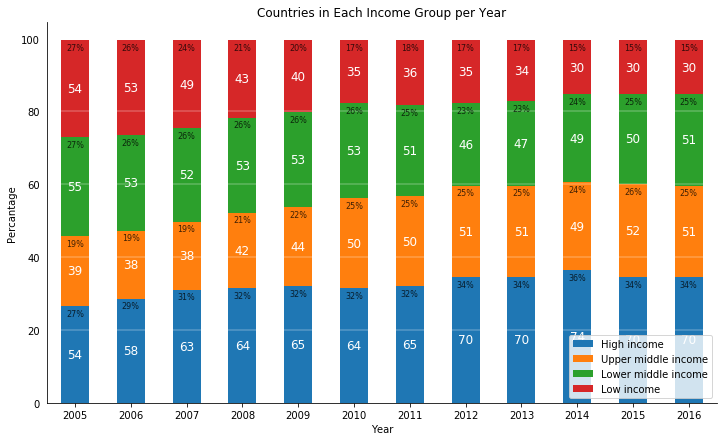

In [12]:
time_change()

<a id='Income Group Overview'></a>
## Income Group Overview 

Below is a plot showing the cumulative distribution of all income groups, along with summary statics and the suggested criteria for income group classification from the World Bank.  Countries fall into income groups based off of their GNI per capita:

| __  | Low income | Lower Middle Income | Upper Middle Income | High Income|
|-----|------------|---------------------|---------------------|------------|
| From | \\$ 130 | \\$ 890 | \\$ 3,420 | \\$ 9,890 |
| To | \\$ 1,610 | \\$ 5,550 | \\$ 14,840 | \\$ 121,650 |
| Average | \\$ 631 | \\$ 2,431 | \\$ 7,386 | \\$ 37,591 |

Because of this information, we will be comparing our indicators to GNI per capita as they pertain to income groups while we look at how income groups differentiate themselves within each indicator.

<a href='#Table of Contents'>Table of Contents</a>

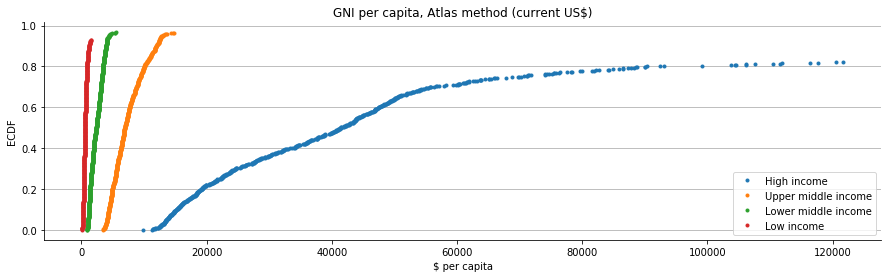

In [13]:
gni_outlook()

 <a id='Executive'></a>

## Our Findings

<a href='#Table of Contents'>Table of Contents</a>

-----

- **<a href='#Economic Policy and Debt'>Economic Policy and Debt</a>**

We have found that GNI and GDP both deal with the economic outlook of a country.  Also, external balance of goods and services are heavily skewed to countries that consume and countries that produce.  Many center their entire economic policies around their production or consumption of resources.  Annual GDP growth is larger among lower income countries than higher income countries.  On average, low income countries outpace high income countries in annual GDP growth by 3.1% annually.  

- **<a href='#Education and Gender Issues'>Education and Gender Issues</a>**

The average required amount of years for schooling among all income groups is between 8 and 10 years with little correlation to GNI per capita.  The average proportion of seats held by women in national parliaments ranges between 21.8% and 17.5% for all income groups which leads to very little correlation to GNI per capita.

- **<a href='#Access to Advanced Communications'>Access to Advanced Communications</a>**

Internet usage varies exponentially among income groups but with the prevalence of the internet, usage appears considerably low.  This is likely due to differences in age and population location (rural vs. urban).  Over time, all income groups have seen a rise in their populations using the internet, which is very much correlated to GNI per capita.  Mobile cellular subscriptions increase with the income level of a country.  Also, all income groups have seen a large increase in mobile cellular subscriptions rates ranging between a 50 and 60 rate increase per group.

- **<a href='#Environment, Resources and Population'>Environment, Resources and Population</a>**

Access to electricity is extremely prevalent among high and upper middle income countries and starts to dip as among lower middle and low income countries.  Access to clean fuels and technologies for cooking relates to access to electricity as the visual depictions of the data look identical.  Total natural resources rents see a few countries, regardless of income group, produce most of the natural resources involved in oil, natural gases, coal, minerals and forests.  There is a significant difference in means of urban population to total population from income group to income group.  This is likely due to the differences in workforce which can be seen in the social protection and labor section.  Urban population is directly negatively correlated to rural population.

- **<a href='#Social Protection and Labor'>Social Protection and Labor</a>**

Labor force participation is roughly the same for high income countries and low income countries at 71%, and is on the rise.  It is possible that the need to work in low income countries to survive and the need to work in high income countries to maintain lifestyle is why they are just about even.  Contributing family workers are those who work with family members who operate their own businesses.  Low income countries high the highest percentage of contributing family workers.  This is likely due to the need to work as a community within a household in order to survive as income categories lessen.  For example, a family in a third world country may own and operate a small grocery store from within their house, or parents employing their children in a restaurant.  The ratio of dependents (under 15 and over 64) to the working population grows as income groups become lower.  This is likely due to the increased rate of fertility for women in lower income countries coupled with the possibility that people over 64 years of age are more likely to have retirement funds in higher income countries.

Employment in services is extremely high among high income countries and dips in lower income countries.  This is likely because high income countries engage in more service related jobs, while low income countries engage in more agriculture related jobs.  While over half of the total workforce in low income countries work in agriculture, not even 1 in 20 of the total workforce do in high income countries.  The difference in means is over 56%.  Employment in industry, among all income groups, have seen a drop.  This is probably due to the increase of automation in manufacturing, quarrying, mining and some utility jobs.

- **<a href='#Health'>Health</a>**

Access to basic drinking water is major in determining income groups.  Although, on average, life expectancy is much higher among high income countries, the minimum life expectancy among most income groups is on the rise per year with low income countries leading the extension averaging a 3 year increase in life expectancy.

-----

As we begin to analyze these indicators, we start to see many patterns as they relate to income groups.  We will now go through the report, extensively, in order to deep dive into what the data is telling us.

<a href='#Table of Contents'>Table of Contents</a>

<a id='Economic Policy and Debt'></a>
## Economic Policy and Debt 

____________

The indicators that pertained to economic policy and debt were:
- ***GNI per capita***
- ***GDP per capita, PPP***
- ***GDP growth (annual %)***
- ***External balance on goods and services (% of GDP)***

GNI and GDP both deal with the economic outlook of a country and are the deciding factors on what income group each country falls under.

External balance of goods and services is only positive among high income countries, 5.4%.  Among upper middle, lower middle and low income countries the balance is -49%, -12.8% and -17.85, respectively.  There are outliers on both ends for all income groups and they are countries that are expected to be outliers because of their surplus, scarcity or serious need/usage of all kinds of resources such as oil, minerals, etc.

    - Countries that have a large positive balance (over 40% of GDP) are Kuwait, Libya, Macao SAR China, Qatar, etc.
    - Countries that have a large negative balance (under 40% of GDP) are Afghanistan, Ghana, United States, United Kingdom, etc.


Annual GDP growth is larger among lower income countries than higher income countries.  Low income countries average a 5.4% annual GDP growth, followed by lower middle income, 4.7%, upper middle income, 3.4% and high income, 2.1% growth annually.  On average, low income countries outpace high income countries in annual GDP growth by 3.1% annually.  This is likely because of the room for growth, untapped resources, government policy, etc. 

<a href='#Executive'>Our Findings</a>

<a href='#Table of Contents'>Table of Contents</a>
_______________

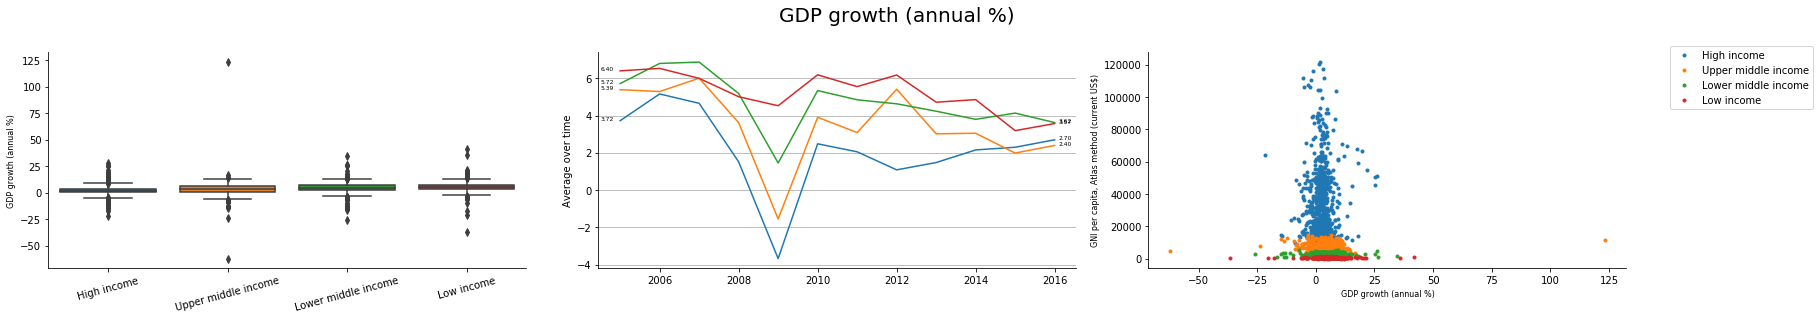

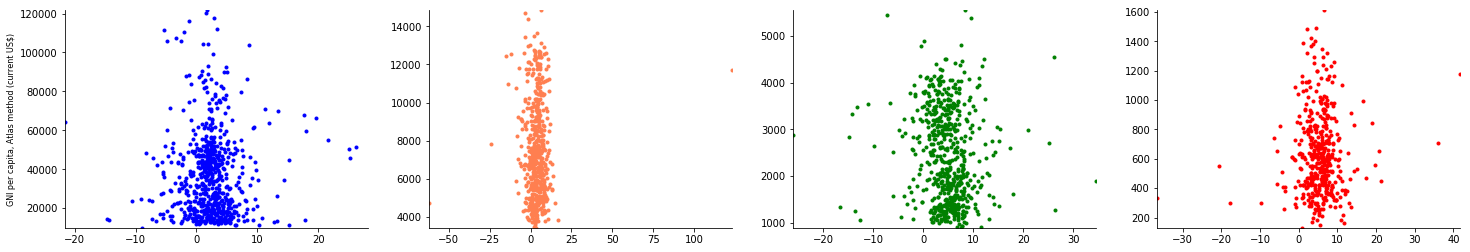

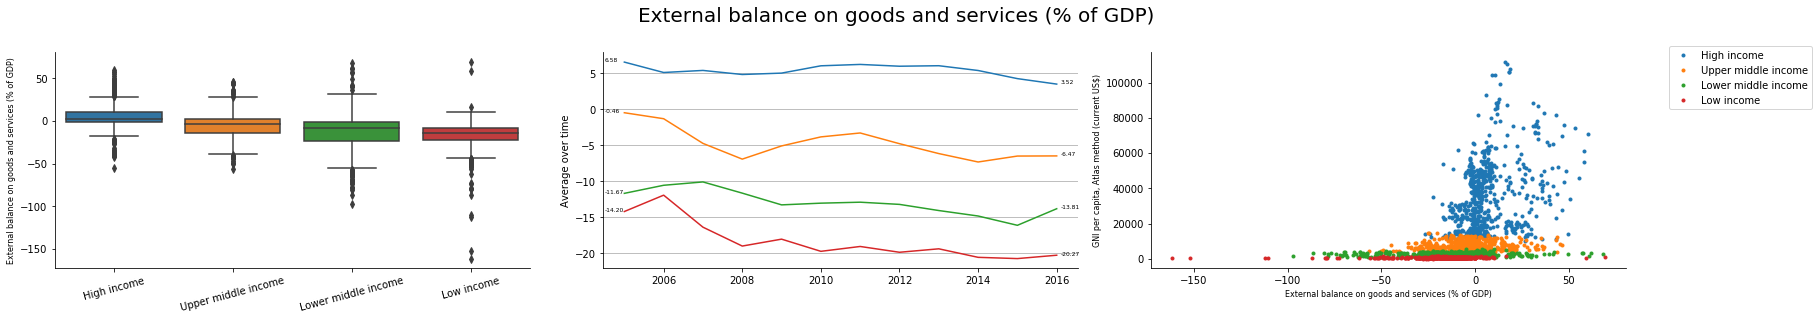

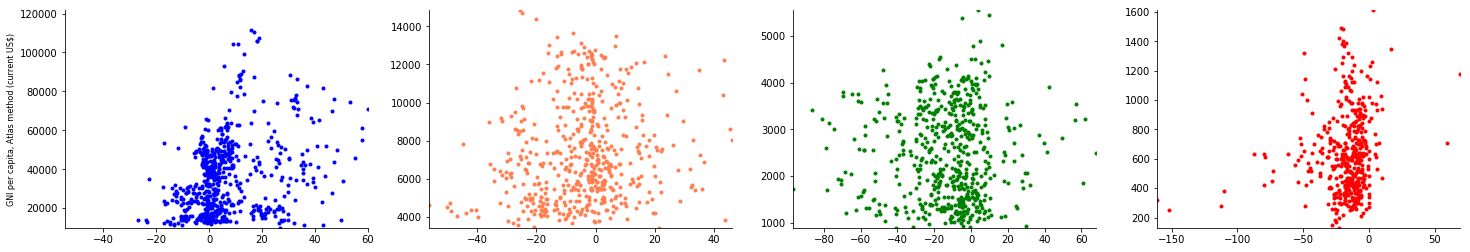

In [14]:
view('GDP growth (annual %)')
view('External balance on goods and services (% of GDP)')

<a id='Education and Gender Issues'></a>
## Education and Gender Issues 

____________

The indicators that pertained to education and gender issues dealt with:
- ***duration of compulsory education***
- ***proportion of seats held by women in national parliaments***

The average required amount of years for schooling among all income groups is between 8 and 10 years with little correlation to GNI per capita.

The proportion of seats held by women in national parliaments ranges between 21.8% and 17.5% for all income groups which is a 4.3% difference in means.  However, there are some countries that have a proportion of seats held by women in national parliaments between 40% and 60% which leads to very little correlation to GNI per capita.

<a href='#Executive'>Our Findings</a>

<a href='#Table of Contents'>Table of Contents</a>
_______________

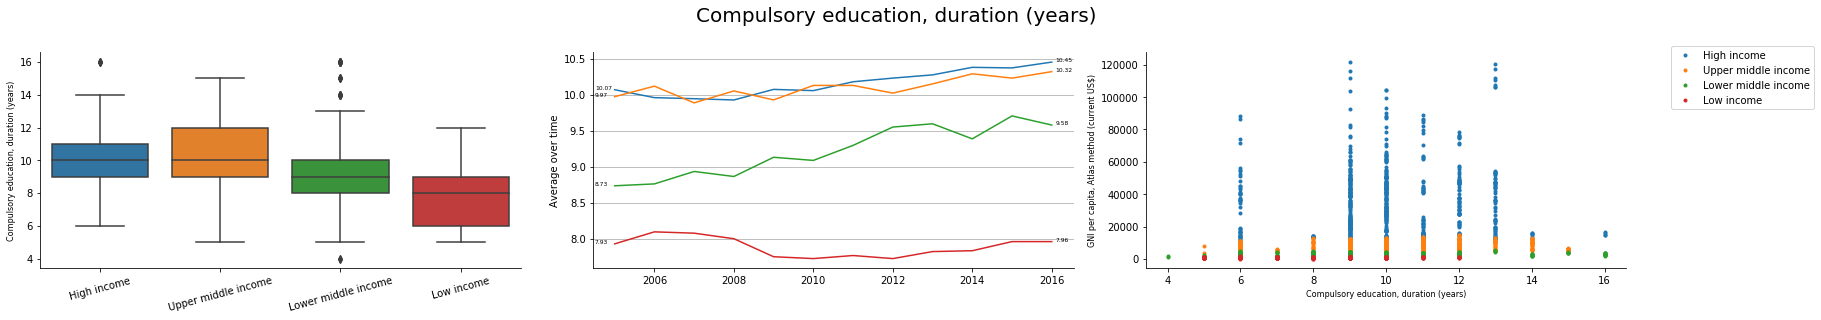

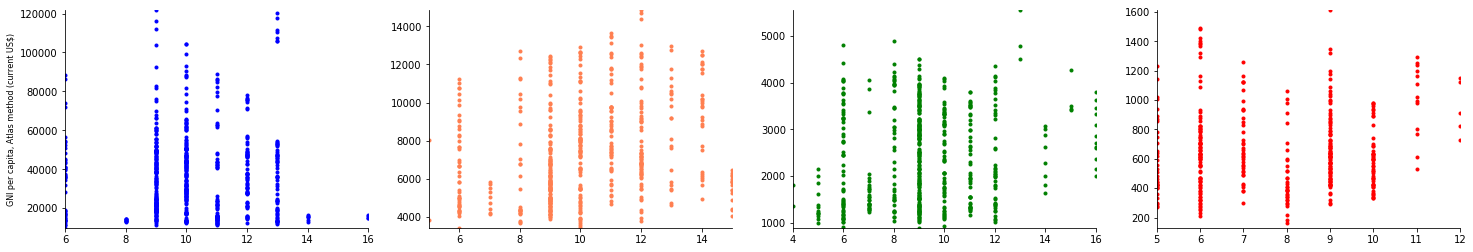

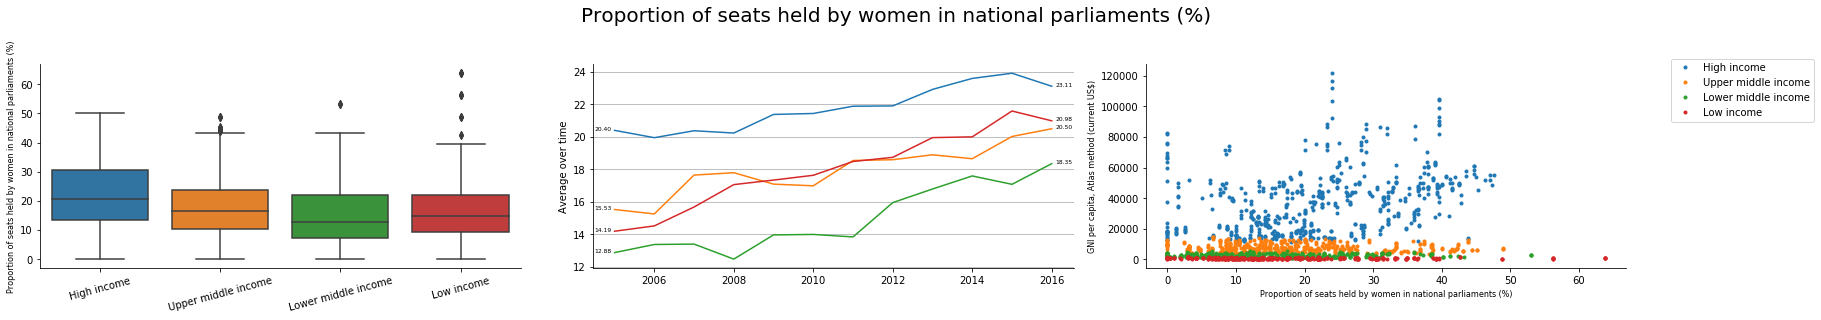

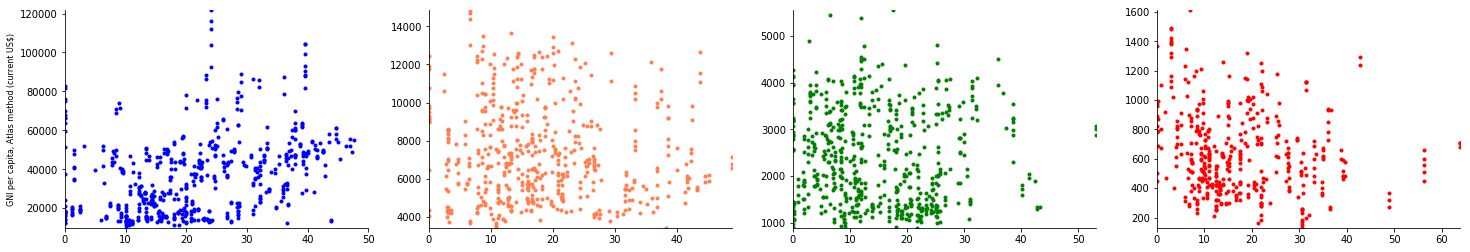

In [15]:
view('Compulsory education, duration (years)')
view('Proportion of seats held by women in national parliaments (%)')

<a id='Access to Advanced Communications'></a>
## Access to Advanced Communications 

____________

The indicators that pertained to access to advanced communications dealt with:
- ***individuals using the internet***
- ***mobile cellular subscriptions***

Internet usage varies exponentially among income groups.  67.6% of individuals in high income countries use the internet as opposed to 36.8%, 17.8% and 4.9% of individuals in upper middle, lower middle and low income countries, respectively.  With the prevalence of the internet, usage appears considerably low.  This is likely due to differences in age and population location (rural vs. urban).  Over time, all income groups have seen a rise in their populations using the internet, which is very much correlated to GNI per capita.

Mobile cellular subscriptions increase with the income level of a country.  Low income countries have a subscription rate of 35.7 while lower middle income countries have a rate of 68.5, upper middle, 102, and high income countries, 118.3.  From 2005 to 2016 all income groups have seen a large increase in mobile cellular subscriptions rates ranging between a 50 and 60 rate increase per group.

<a href='#Executive'>Our Findings</a>

<a href='#Table of Contents'>Table of Contents</a>

_______________

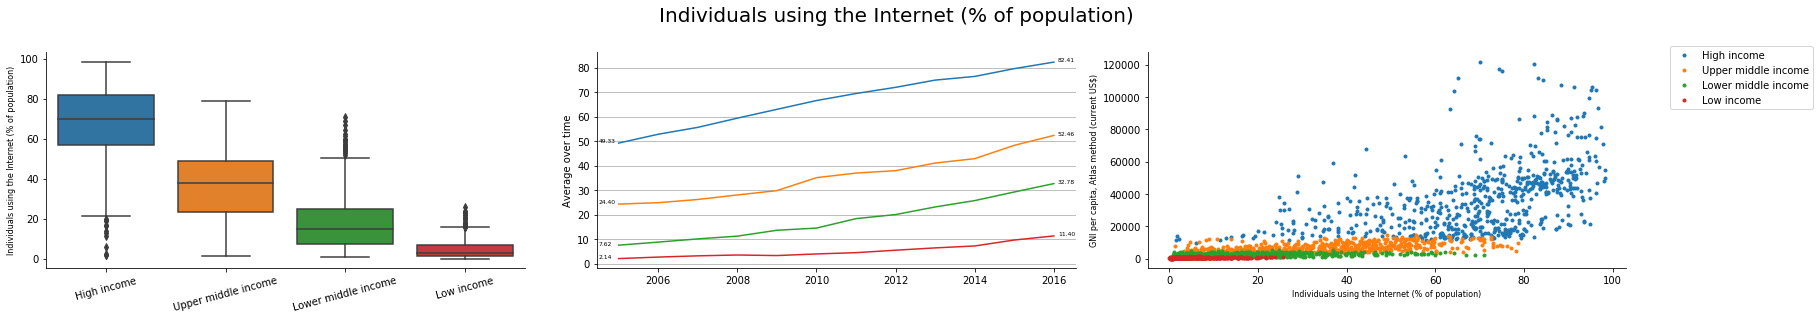

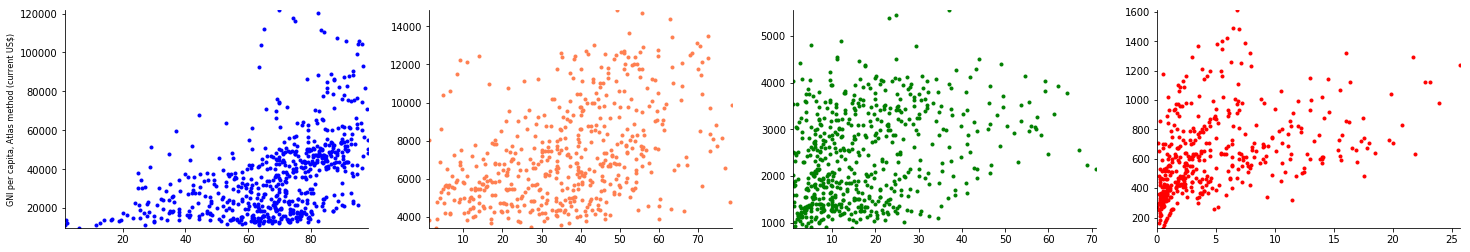

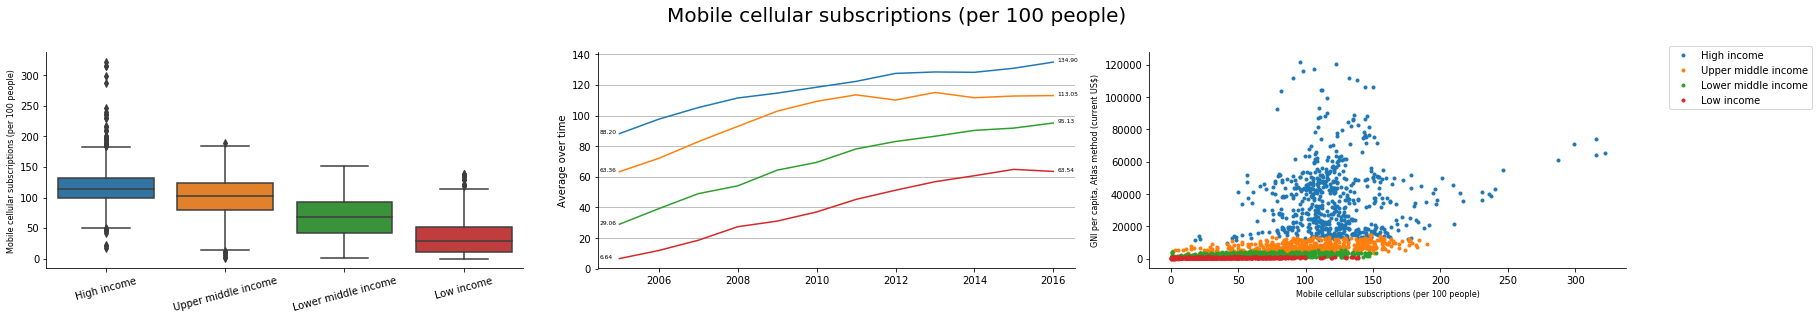

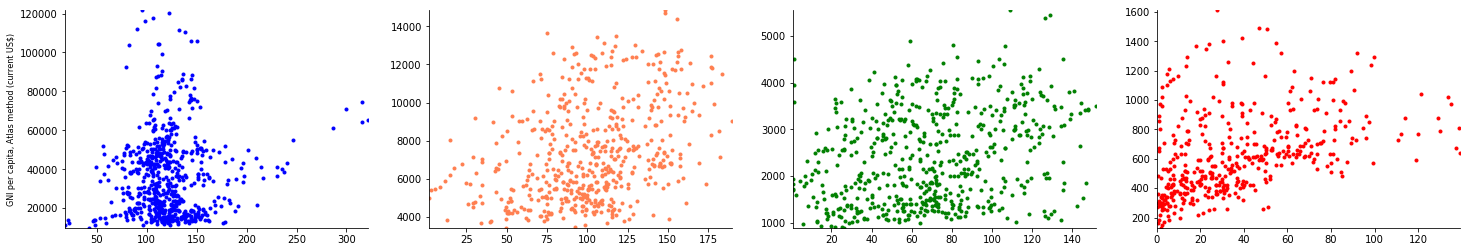

In [16]:
view('Individuals using the Internet (% of population)')
view('Mobile cellular subscriptions (per 100 people)')

<a id='Environment, Resources and Population'></a>
## Environment, Resources and Population 

____________

The indicators that pertained to environment, resources and population involved:
- ***access to electricity***
- ***access to clean technology and fuels for cooking***
- ***total natural resources rents***
- ***urban and rural population***

Access to electricity is extremely prevalent among high and upper middle income countries with over 94% of their populations having access.  Lower middle income countries have the widest range in access but average 77.4%, while low income countries average 33%.  There is a significant difference in means with 66.5% more of the population in high income countries having access to electricity than low income countries.  The gap from low income countries to lower middle income countries is extremely wide as well with a 44.5% difference in population access.

Access to clean fuels and technologies for cooking is extremely prevalent at 98% and 84.4%, respectively, among high and upper middle income countries.  Lower middle income countries average 49.8%, while low income countries average only 10.9%.  From upper middle to lower middle and from lower middle to low income countries, the difference in means ranges between 30% and 40%.  This may relate to access to electricity as the visual depictions of the data look identical.  From 2005 to 2016, lower income countries are losing access to clean fuels and technologies for cooking with lower middle income countries dropping 13% and low income countries dropping 6%.

Total natural resources rents are 4.9% of the total GDP for high income countries and rises to 12.2% for low income countries.  There are several outliers in each income group that go up to 70% of a country's total GDP, which means that a few countries, regardless of income group, produce most of the natural resources involved in oil, natural gases, coal, minerals and forests.  Because of the wide variety of outliers, natural resources rents have very little negative, almost no, correlation to GNI per capita.

There is a significant difference in means of urban population to total population from income group to income group of about 12% to 15% with high income countries (77%) having 44.5% more of its total population in urban areas than low income countries (32.4%).  This is likely due to the differences in workforce which can be seen in the social protection and labor section.  Urban population is directly negatively correlated to rural population.

<a href='#Executive'>Our Findings</a>

<a href='#Table of Contents'>Table of Contents</a>

_______________

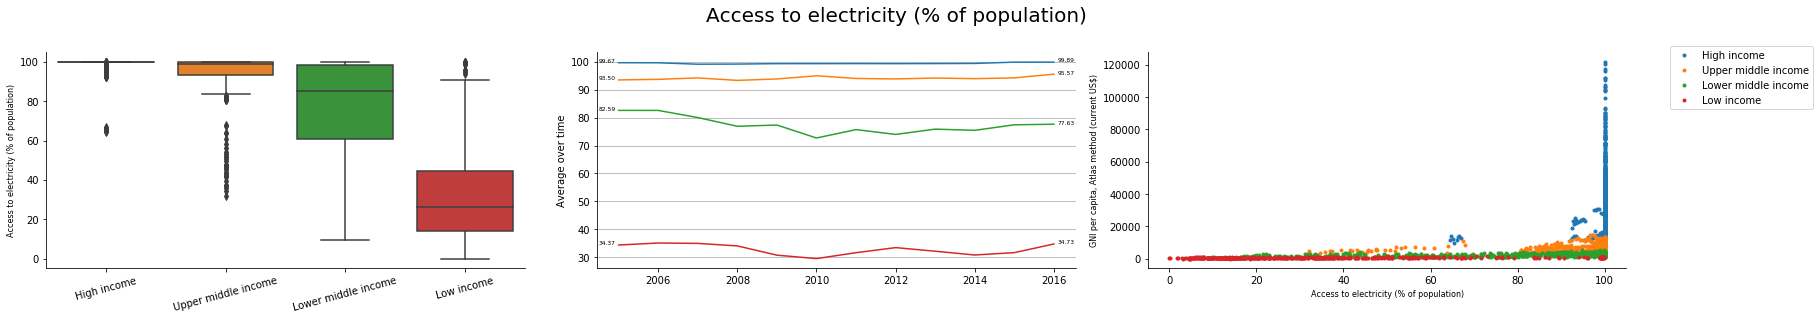

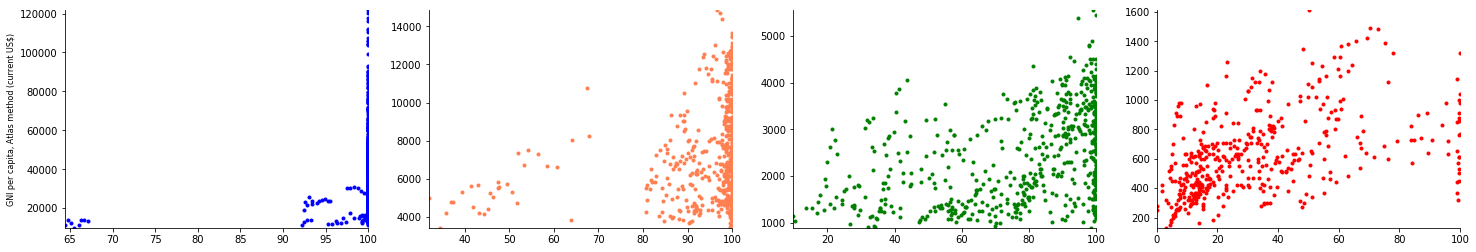

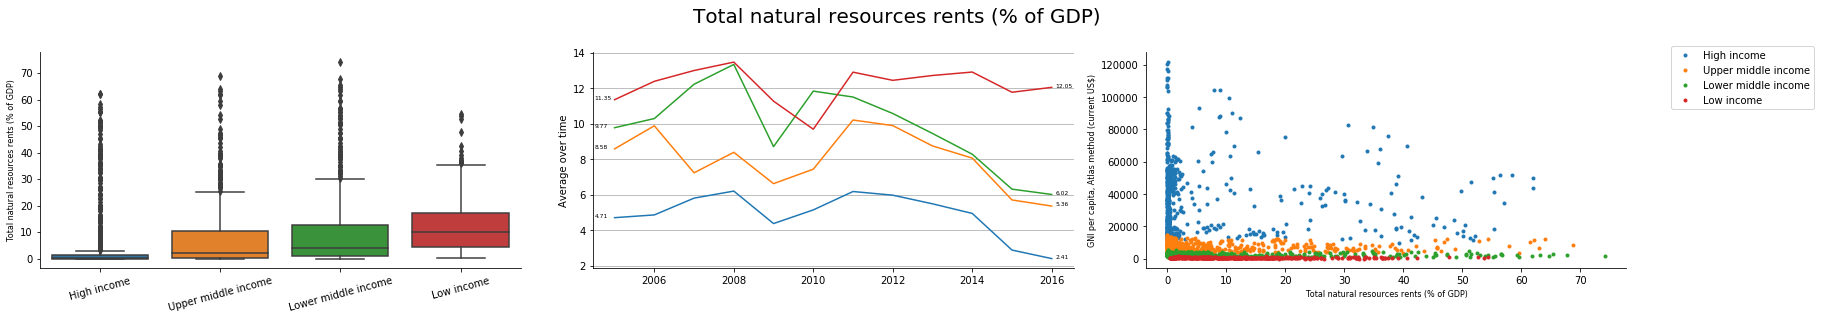

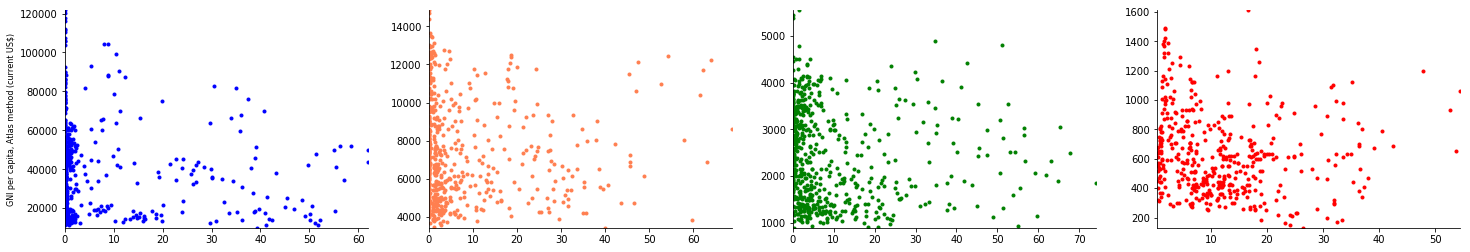

In [17]:
view('Access to electricity (% of population)')
view('Total natural resources rents (% of GDP)')

<a id='Social Protection and Labor'></a>
## Social Protection and Labor 

____________

The indicators that pertained to social protection and labor were:
- ***labor force participation***
- ***contributing family workers***
- ***dependents of the workforce***
- ***employment in agriculture***
- ***employment in industry***
- ***employment in service***

Labor force participation is roughly the same for high income countries and low income countries at 71%, and is on the rise.  It drops to under 65% percent for upper middle and lower middle income countries.  It is possible that the need to work in low income countries to survive and the need to work in high income countries to maintain lifestyle is why they are just about even.

Contributing family workers are those who work with family members who operate their own businesses.  High income countries have only 1% of their total workforce as contributing family workers, while the rate exponentially rises as income groups become lower with one quarter of the workforce in low income countries being contributing family members.  This is likely due to the need to work as a community within a household in order to survive as income categories lessen.  For example, a family in a third world country may own and operate a small grocery store from within their house, or parents employing their children in a restaurant.

The ratio of dependents to the working population grows as income groups become lower.  High income countries have a dependency ratio of 46.5% and the ratio rises to 83.9% among low income countries.  This is likely due to the increased rate of fertility for women in lower income countries coupled with the possibility that people over 64 years of age are more likely to have retirement funds in higher income countries.

Employment in services is extremely high among high income countries with 71.8% of the total workforce in that sector.  The difference in means from income group to income group ranges between 12% and 17%.  While high income countries have 7 in 10 people from their total workforce in industry, low income countries have 3 in 10.  This is likely because high income countries engage in more service related jobs, while low income countries engage in more agriculture related jobs.

Employment in industry is roughly the same in high income and upper middle income countries.  Although some high income countries have up to 60% of the total workforce employed in industry, high income countries have 1 in 4 workers in industry and average 12.6% more of their total workforce in industry than low income countries which have 1 in 10 workers.  From 2005 to 2016, all income groups have seen a drop, 1% to 3%, in employment in industry.  This is probably due to the increase of automation in manufacturing, quarrying, mining and some utility jobs.

While over half of the total workforce in low income countries work in agriculture, not even 1 in 20 of the total workforce do in high income countries.  The difference in means is over 56%.

<a href='#Executive'>Our Findings</a>

<a href='#Table of Contents'>Table of Contents</a>

_______________

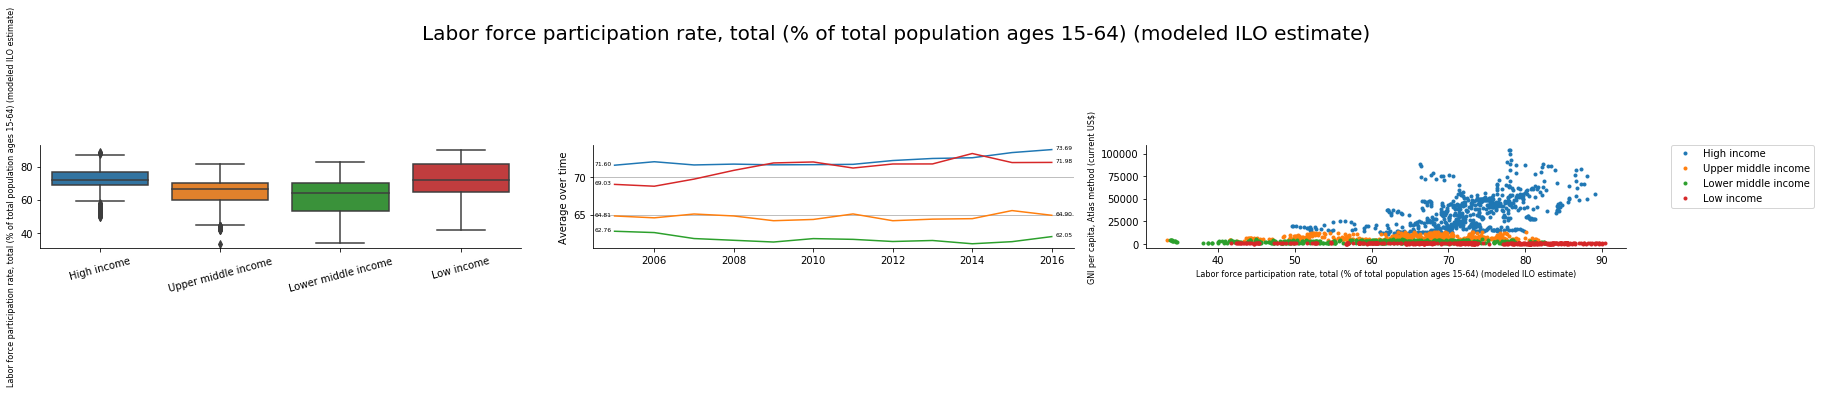

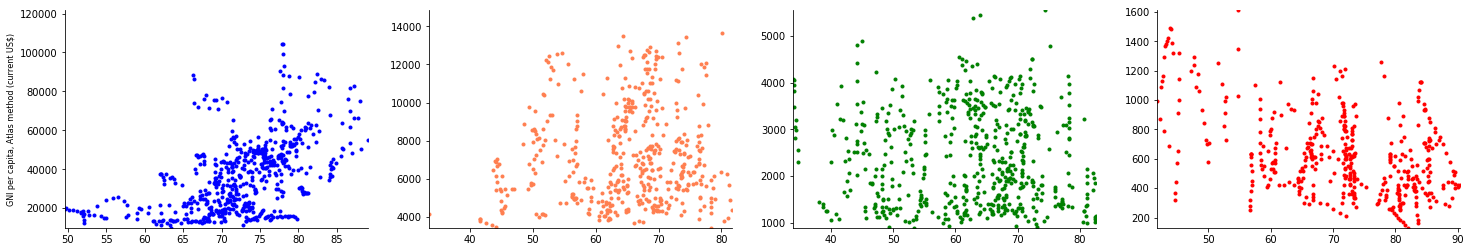

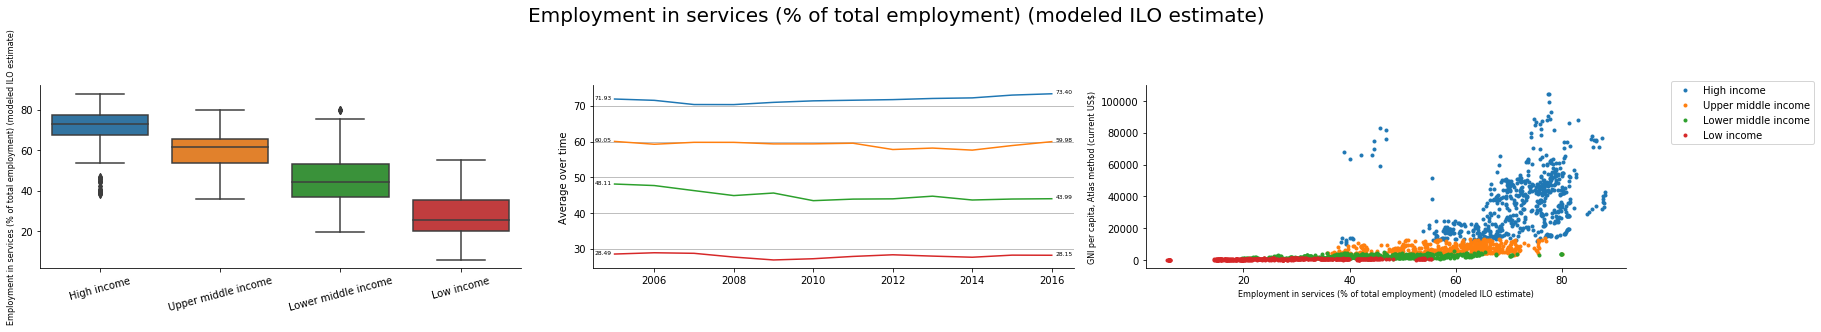

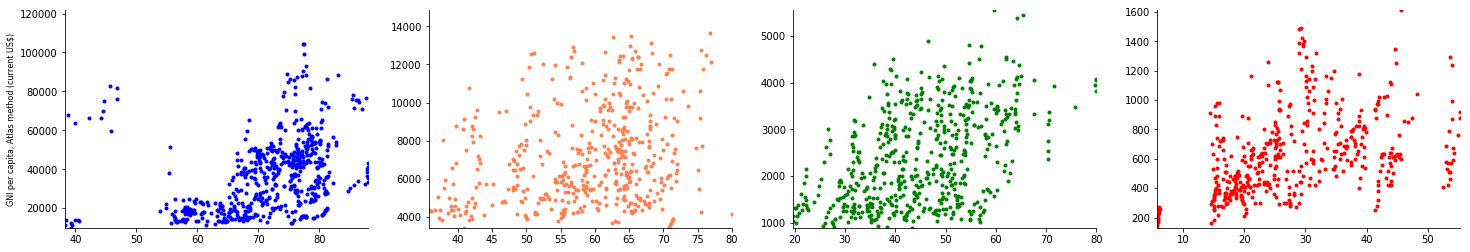

In [18]:
view('Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)')

view('Employment in services (% of total employment) (modeled ILO estimate)')

<a id='Health'></a>
## Health 

____________

The indicators that pertained to health dealt with access to:
- ***basic drinking water***
- ***fertility rates***
- ***infant mortality rates***
- ***life expectancy***

Access to basic drinking water is major in determining income groups.  Almost 99% of high income countries have access as opposed to 59% of low income countries, a 40% difference in population access with the middle income countries ranging in between.  Access to basic needs, such as water, may lead to increased life expectancy and lower infant mortality rates.

The average fertility rate among income groups rises as countries fall into lower income categories.  High income mothers have roughly 2 children, while upper middle mothers range between 2 and 3, lower middle between 2 and 4, and low income mothers between 4 and 6 children.

Infant mortality exponentially grows as income levels decline among countries.  Low income countries have an infant mortality rate 9 times that of high income countries.  Although the rate is high, low income countries have seen a large decline in infant mortality rates from 2005 to 2016 dropping from 66 deaths per 1000 births to 51.

Although, on average, life expectancy is much higher among high income countries, the minimum life expectancy among most income groups is on the rise per year with low income countries leading the extension averaging a 3 year increase in life expectancy.

<a href='#Executive'>Our Findings</a>

<a href='#Table of Contents'>Table of Contents</a>

_______________

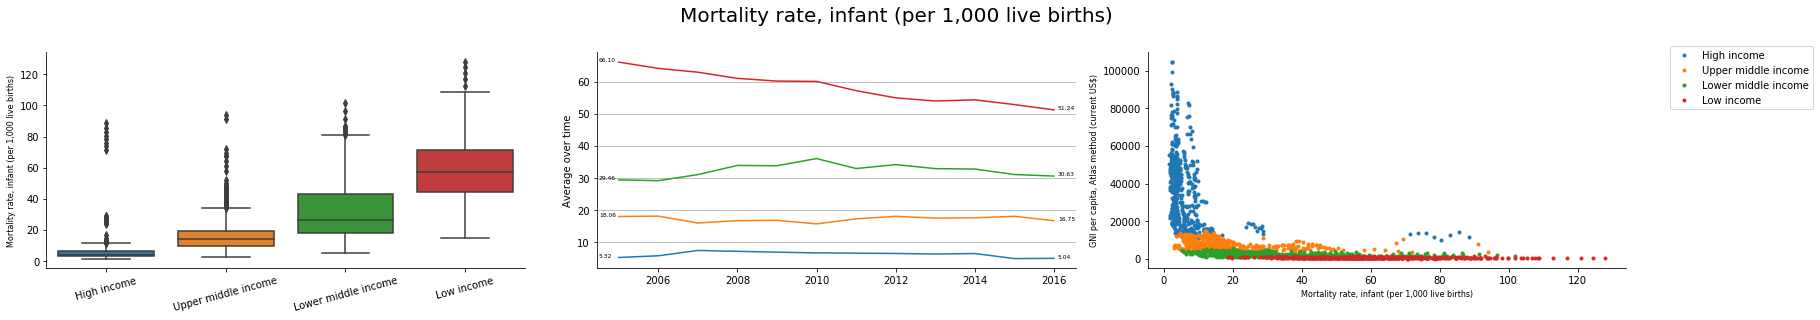

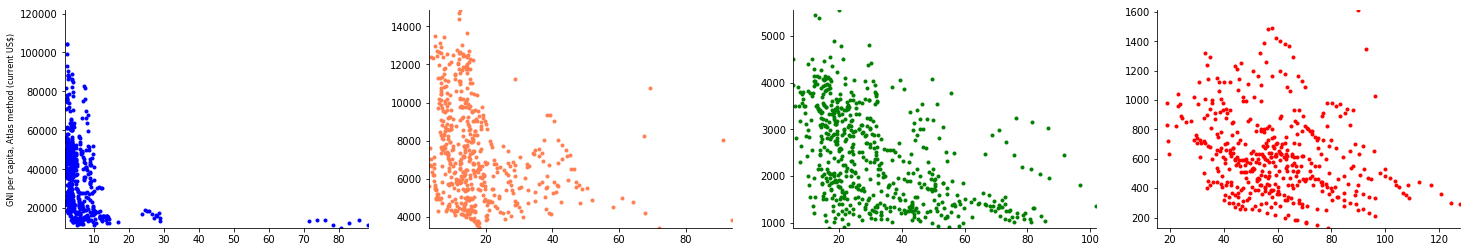

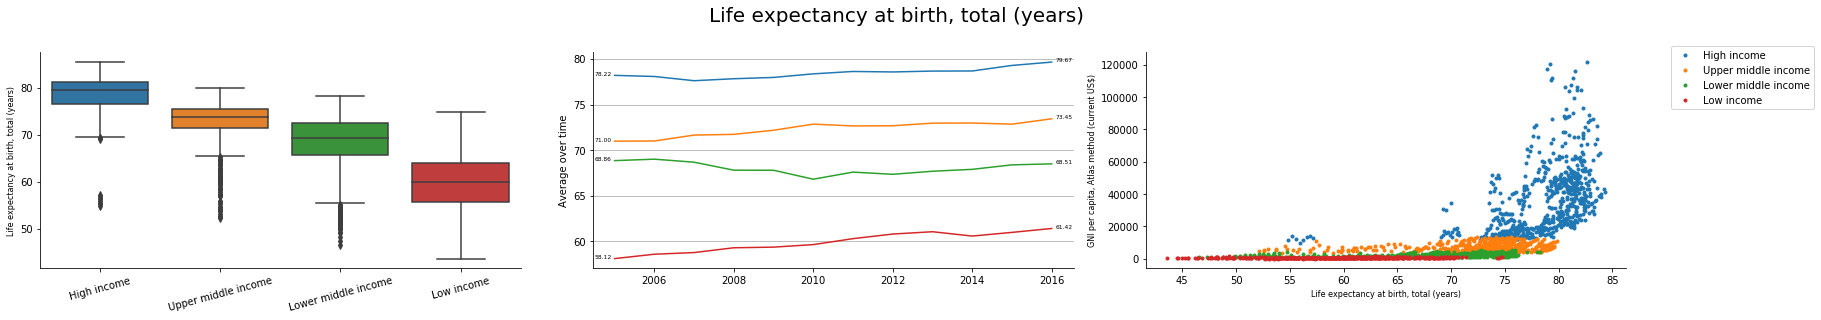

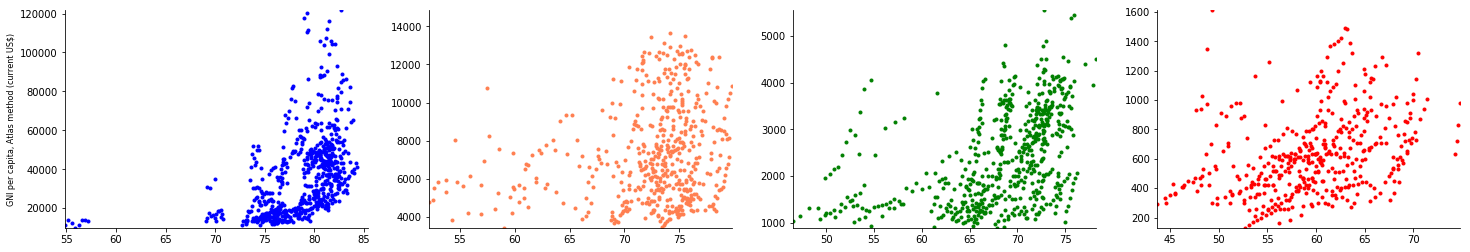

In [19]:
view('Mortality rate, infant (per 1,000 live births)')
view('Life expectancy at birth, total (years)')

<a id='Diving Deeper with Indicator Correlations'></a>
## Diving Deeper with Indicator Correlations 


Many of the features have positive and negative correlation with each other.  In a more complex project, it would be great to see which ones do and don't and find the reasons why.  Because this is a classification project, the main concern pertains to GNI per capita and it's relation to the feaures.

<a href='#Table of Contents'>Table of Contents</a>

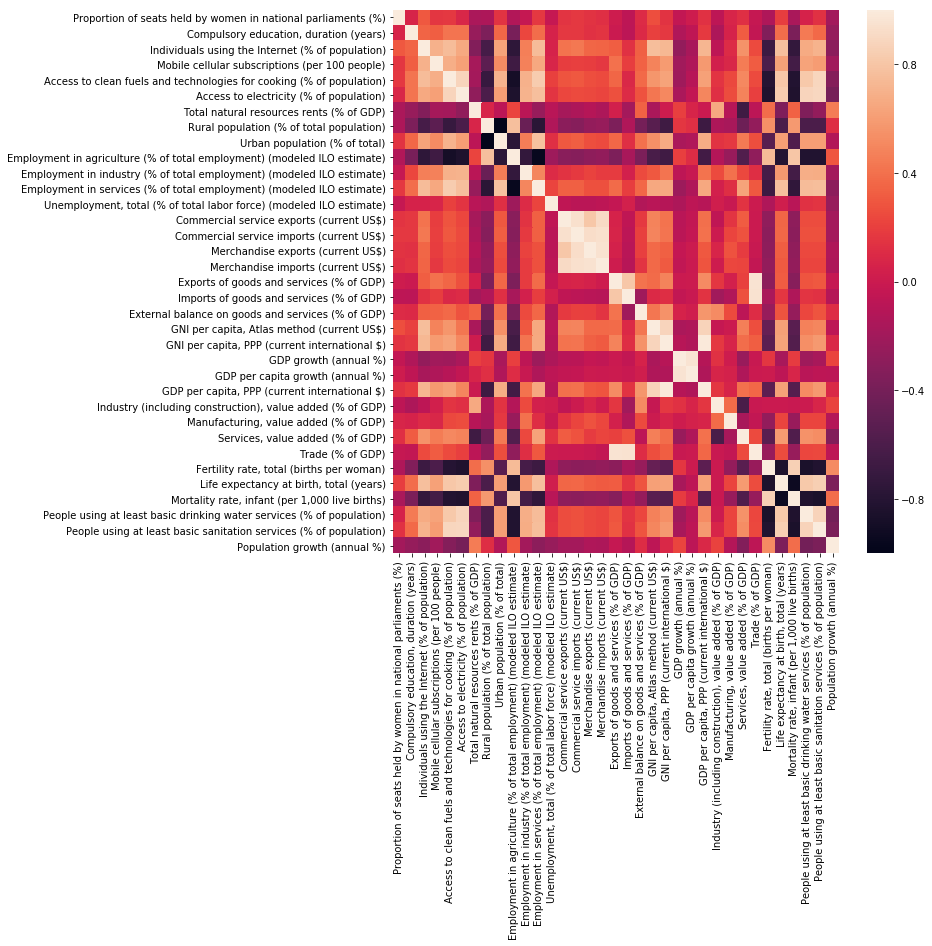

In [20]:
plt.figure(figsize=(10,10))
correlations = wdi_corr.corr()
sns.heatmap(correlations,
           xticklabels=correlations.columns.values,
           yticklabels=correlations.columns.values)
plt.show()

------
<a id='End'></a>
## Conclusion 

In conclusion, we have found that:
- Countries change income groups from year to year
- Higher income groups are growing while lower income groups are shrinking.
- Features are showing a growth in access and standards of living among all income groups.
- This all leads to the world becoming more developed.


The major indicator that determines income group is GNI per capita.  Countries fall into certain groups based off of this indicator.  This indicator is also correlated to many world development indicators and is worth a deep dive.

In analyzing our data, we were able to separate our indicators into various categories:
- Economic Policy and Debt
- Education and Gender Issues
- Access to Advanced Communications
- Environment, Resources and Population
- Social Protection and Labor
- Health

As we analyzed these indicators, we have seen many patterns as they relate to income groups.  We will now use what we have found to begin creating a machine learning model.

<a href='#Table of Contents'>Table of Contents</a>